## Imports

In [1]:
import os
#print(os.getcwd())
current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
os.chdir(parent_path)
#os.chdir('energy-analysis-and-predictions')
#print(os.getcwd())

In [83]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import math
from utils.parameters import ENERGY_PRICE_FOLDER, \
                             ENERGY_COMPANIES_FOLDER
from load_data.load_energy_prices import load_energy_prices_data, \
                            load_energy_prices_from_all_files         
from predict_data.create_train_test_data import get_scaled_X_y_train_and_test_data
from predict_data.create_simple_train_test_data import get_X_y_scaled_and_splited                       
from process_data.preprocessor import scale_data
from predict_data.load_gru_model import load_gru_model          
from predict_data.model_methods import compile_model, train_model,evaluate_model, predict_model                                          
from visualize_data.plot_price_with_interactive_timestamps import plot_price_with_interactive_timestamps   
from visualize_data.plot_model_history import plot_history, plot_history_loss_mse
from visualize_data.plot_predict_vs_test import plot_predict_vs_test


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Energy Prices 

## Load data for one file using years: 2018  and 2020 

In [1]:
folder_energy_test_2018 = os.path.join(ENERGY_PRICE_FOLDER, 'Gro_handelspreise_2018_01_01_2018_12_31_Tag.csv')
price_2018 = load_energy_prices_data(folder_energy_test_2018, 'Germany')
price_2018.head()

NameError: name 'os' is not defined

In [71]:
price_2018.dtypes

Date               datetime64[ns]
Germany [€/MWh]           float64
dtype: object

In [41]:
folder_energy_test_2020 = os.path.join(ENERGY_PRICE_FOLDER, 'Gro_handelspreise_2020_01_01_2020_12_31_Tag.csv')
price_2020 = load_energy_prices_data(folder_energy_test_2020, 'Germany')
price_2020.head()

Germany/Luxembourg [€/MWh]
count of not null values = 366
∅ residents Germany/Luxembourg [€/MWh]
count of not null values = 366
Germany/Luxembourg/Austria [€/MWh]
count of not null values = 0


,Date,Germany [€/MWh]
0,2020-01-01,33.700
1,2020-01-02,38.020
2,2020-01-03,29.595
3,2020-01-04,24.705
4,2020-01-05,34.835


## Energy price loading all files 

In [15]:
country = 'Germany'
folder = ENERGY_PRICE_FOLDER
energy_prices_df = load_energy_prices_from_all_files(folder, country)

Gro_handelspreise_2021_01_01_2021_12_31_Tag.csv
	Germany/Luxembourg [€/MWh]
		 df.shape =(365, 20)
	∅ residents Germany/Luxembourg [€/MWh]
		 df.shape =(365, 20)
	Germany/Luxembourg/Austria [€/MWh]
	average df


Gro_handelspreise_2020_01_01_2020_12_31_Tag.csv
	Germany/Luxembourg [€/MWh]
		 df.shape =(366, 20)
	∅ residents Germany/Luxembourg [€/MWh]
		 df.shape =(366, 20)
	Germany/Luxembourg/Austria [€/MWh]
	average df


Gro_handelspreise_2018_01_01_2018_12_31_Tag.csv
	Germany/Luxembourg [€/MWh]
		 df.shape =(92, 20)
	∅ residents Germany/Luxembourg [€/MWh]
	Germany/Luxembourg/Austria [€/MWh]
		 df.shape =(273, 20)
	concat df


Gro_handelspreise_2019_01_01_2019_12_31_Tag.csv
	Germany/Luxembourg [€/MWh]
		 df.shape =(365, 20)
	∅ residents Germany/Luxembourg [€/MWh]
		 df.shape =(41, 20)
	Germany/Luxembourg/Austria [€/MWh]
	df0 taken


Gro_handelspreise_2022_01_01_2022_12_31_Tag.csv
	Germany/Luxembourg [€/MWh]
		 df.shape =(365, 20)
	∅ residents Germany/Luxembourg [€/MWh]
		 df.shape =(365

In [16]:
energy_prices_df.shape

(1826, 1)

In [40]:
round(energy_prices_df.shape[0]*0.9)

1643

In [42]:
energy_prices_df.shape[0]-round(energy_prices_df.shape[0]*0.9)

183

In [89]:
plot_price_with_interactive_timestamps(energy_prices_df, energy_prices_df.index, energy_prices_df.columns, 'Energy prices Germany', '[€/MWh]')

# Train and test split and Normalize data range (-1,1)

In [71]:
TRAIN_TEST_SEQUENCE = round(energy_prices_df.shape[0] * 0.011) # math.ceil()
print('INPUT_LENGTH_SPLIT =', TRAIN_TEST_SEQUENCE)
TRAIN_TEST_RATIO = 0.9
N_FEATURES = 1
OUTPUT_LENGTH = 1
FOLDS_SEQUENCE = 1
FOLD_LENGTH_RATIO = 0.2
TARGET = energy_prices_df.columns[0]

INPUT_LENGTH_SPLIT = 20


In [72]:
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler = get_scaled_X_y_train_and_test_data(energy_prices_df,
                                TRAIN_TEST_RATIO,
                                TRAIN_TEST_SEQUENCE,
                                FOLD_LENGTH_RATIO,
                                FOLDS_SEQUENCE,
                                OUTPUT_LENGTH,
                                TARGET) 

length train data 1643
length test data 203
folds length = 40


In [73]:
len_train = round(energy_prices_df.shape[0]*TRAIN_TEST_RATIO)
len_test = energy_prices_df.shape[0]- len_train + TRAIN_TEST_SEQUENCE

INPUT_LENGTH_FOLD_TEST = round((len_test - OUTPUT_LENGTH)*FOLD_LENGTH_RATIO)
print('INPUT_LENGTH_FOLDS =', INPUT_LENGTH_FOLD_TEST)

total_number_train_folds = len_train - INPUT_LENGTH_FOLD_TEST - OUTPUT_LENGTH + FOLDS_SEQUENCE
total_number_test_folds = len_test - INPUT_LENGTH_FOLD_TEST - OUTPUT_LENGTH + FOLDS_SEQUENCE
print(f'{total_number_train_folds} train folds generated')
print(f'{total_number_test_folds} test folds generated')

INPUT_LENGTH_FOLDS = 40
1603 train folds generated
163 test folds generated


In [74]:
# test

assert X_train_scaled.shape == (total_number_train_folds, INPUT_LENGTH_FOLD_TEST, N_FEATURES)
assert X_test_scaled.shape == (total_number_test_folds, INPUT_LENGTH_FOLD_TEST, N_FEATURES)

print('test train and test split for X and y strides:')
print('')
len_folds = X_train_scaled.shape[1]
print('X train fold 0, values last 5 elements')
print( X_train_scaled[0, len_folds-5 :,:])
print('')
print('X train fold 1, values last 5 elements')
print(X_train_scaled[1, len_folds-5 :, :])
print('')
print('y train element 0')
print(y_train_scaled[0, 0])
assert y_train_scaled[0,0] in X_train_scaled[1, :, :]
assert y_train_scaled[0,0] not in X_train_scaled[0, :, :]

test train and test split for X and y strides:

X train fold 0, values last 5 elements
[[-0.64968716]
 [-0.64158512]
 [-0.64114391]
 [-0.63059522]
 [-0.66693406]]

X train fold 1, values last 5 elements
[[-0.64158512]
 [-0.64114391]
 [-0.63059522]
 [-0.66693406]
 [-0.67262955]]

y train element 0
-0.6726295480983665


##  Model

In [78]:
units_gru_layers = 32
regularizer = 'L1L2'
penalty = 0.05
activation_function = 'tanh'
opt_compiler = 'adam'
model_metric = 'mae'
patience = 25
epochs = 100
batch_size = 32
foldername = 'raw_data/saved_models'
filename_model = f'model_gru_units_{units_gru_layers}_{regularizer}_{activation_function}_{opt_compiler}_{model_metric}_epochs_{epochs}_bsize_{batch_size}.h5'
folder_model = foldername + '/' + filename_model
#folder_model= os.path.join(ENERGY_PRICE_FOLDER, full_name)
print(folder_model)

raw_data/saved_models/model_gru_units_32_L1L2_tanh_adam_mae_epochs_100_bsize_32.h5


In [79]:
model_scaled = load_gru_model(X_train_scaled, y_train_scaled,activation_function, regularizer, penalty)
model_scaled = compile_model(model_scaled, learning_rate=0.001, optimizer=opt_compiler, metric=model_metric)
(fited_model_scaled, history_scaled) = train_model(model_scaled, X_train_scaled, y_train_scaled, patience, epochs, batch_size)
fited_model_scaled.save(folder_model)

array([<AxesSubplot:title={'center':'MSE, split_ratio= 0.9, split_seq= 20,    fold_ratio= 0.2, fold_seq= 1, layer_1= 32, layer_2= 32'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot:title={'center':'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

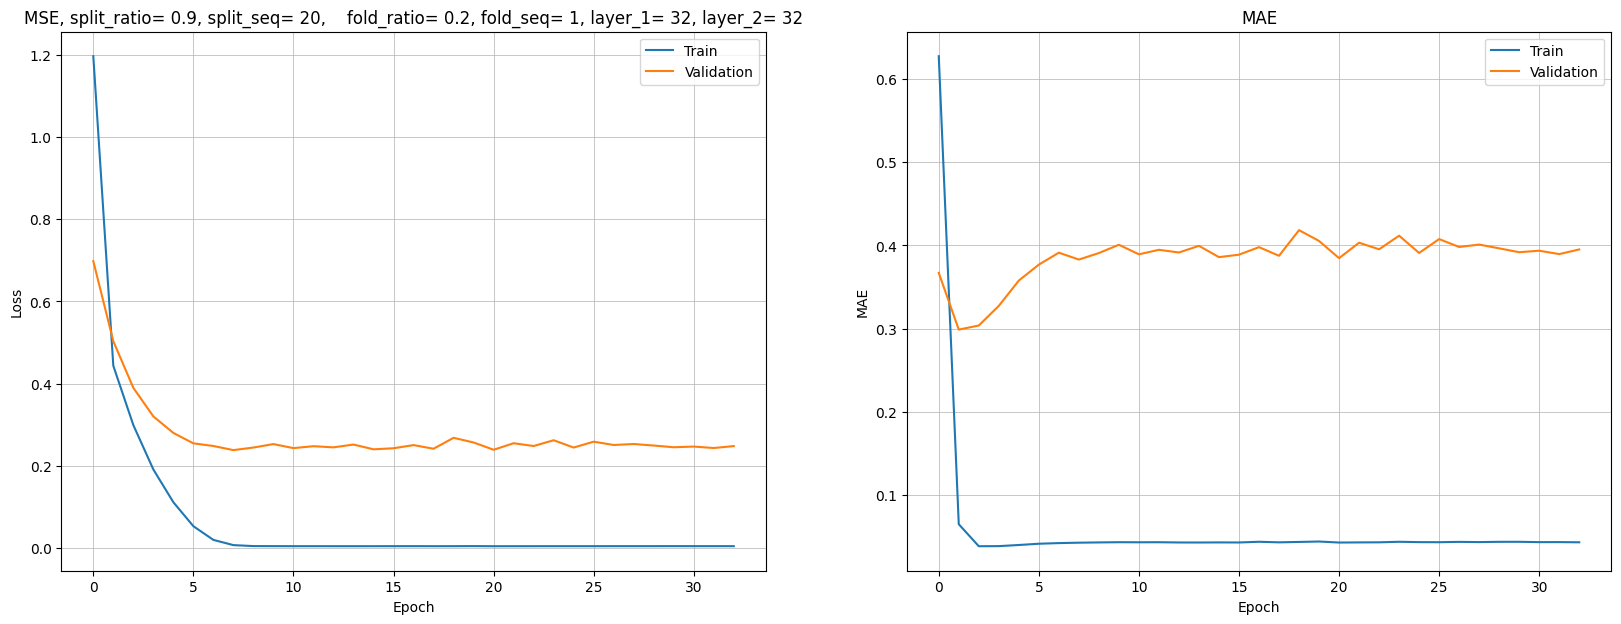

In [80]:
plot_history(history_scaled, TRAIN_TEST_RATIO, TRAIN_TEST_SEQUENCE, FOLD_LENGTH_RATIO, FOLDS_SEQUENCE, 32, 32)

In [98]:
y_pred_scaled = predict_model(fited_model_scaled, X_test_scaled)
y_test_unscaled = scaler.inverse_transform(y_test_scaled[:])
y_pred_unscaled = scaler.inverse_transform(y_pred_scaled)
plot_predict_vs_test(energy_prices_df,
                         y_test_unscaled,
                         y_pred_unscaled,
                         'Germany energy price using normalization', TARGET)

6/6 [==============================] - 0s 9ms/step


# Simple split

In [91]:
split_ratio = 0.9
memory_split_ratio = 0.011
stride_ratio = 0.2
target = energy_prices_df.columns[0]
X_train, y_train, X_test, y_test, scaler = get_X_y_scaled_and_splited(energy_prices_df, split_ratio, memory_split_ratio, stride_ratio, target)

In [92]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1602, 41, 1)
(1602, 1)
(162, 41, 1)
(162, 1)


In [93]:
units_gru_layers = 32
regularizer = None
penalty = 0
activation_function = 'tanh'
opt_compiler = 'adam'
model_metric = 'mae'
patience = 25
epochs = 100
batch_size = 32
foldername = 'raw_data/saved_models'
filename_model = f'model_gru_units_{units_gru_layers}_{regularizer}_{activation_function}_{opt_compiler}_{model_metric}_epochs_{epochs}_bsize_{batch_size}.h5'
folder_model = foldername + '/' + filename_model

In [95]:
model_v2 = load_gru_model(X_train, y_train,activation_function, regularizer, penalty)
model_v2 = compile_model(model_v2, learning_rate=0.001, optimizer=opt_compiler, metric=model_metric)
(model_v2, history_v2) = train_model(model_v2, X_train, y_train, patience, epochs, batch_size)
model_v2.save(folder_model)

array([<AxesSubplot:title={'center':'MSE, split_ratio= 0.9, split_seq= 20,    fold_ratio= 0.2, fold_seq= 1, layer_1= 32, layer_2= 32'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot:title={'center':'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

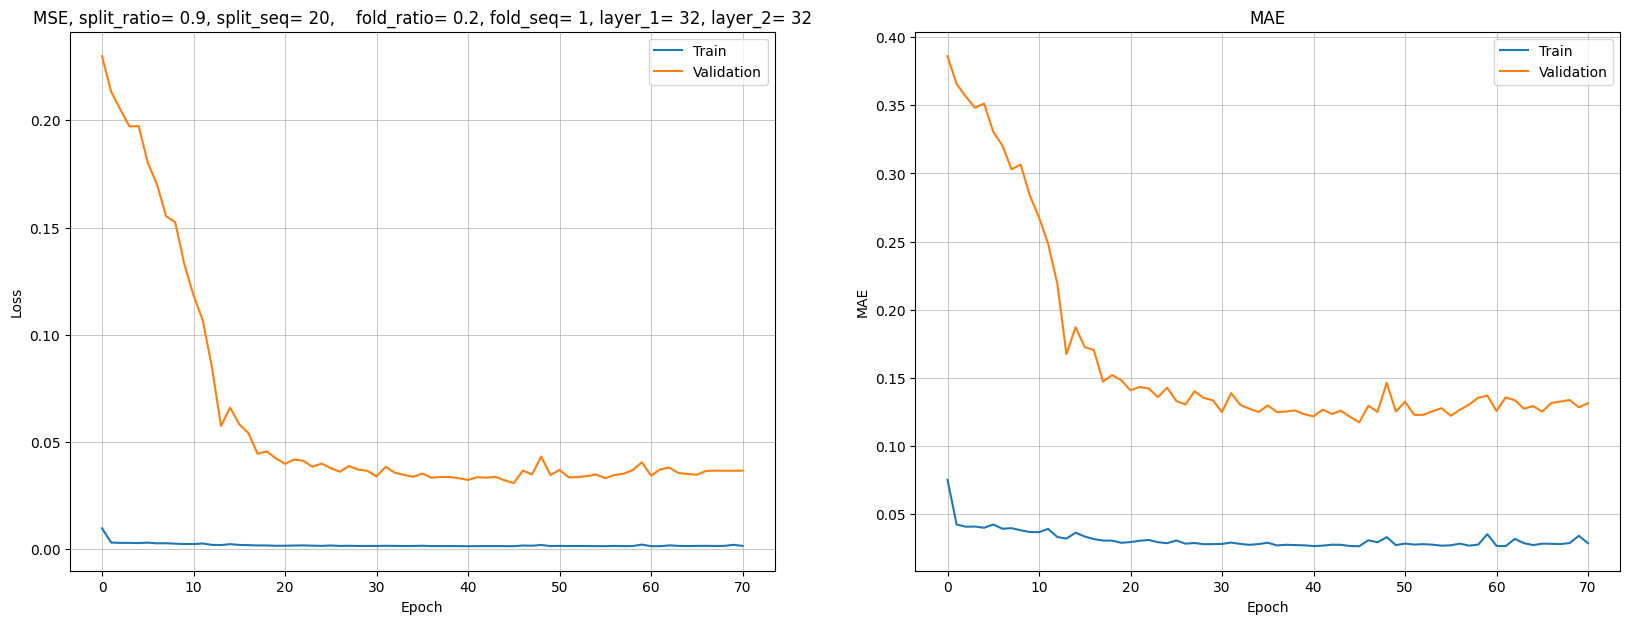

In [96]:
plot_history(history_v2, TRAIN_TEST_RATIO, TRAIN_TEST_SEQUENCE, FOLD_LENGTH_RATIO, FOLDS_SEQUENCE, 32, 32)

In [105]:
y_pred_scaled = predict_model(model_v2, X_test)
y_test_unscaled = scaler.inverse_transform(y_test[:])
y_pred_unscaled = scaler.inverse_transform(y_pred_scaled)
plot_predict_vs_test(energy_prices_df,
                         y_test_unscaled,
                         y_pred_unscaled,
                         'Germany energy price using normalization', target)

6/6 [==============================] - 0s 9ms/step
